In [1]:
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize, LogNorm
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.pyplot as plt
import scqubits
from tqdm import tqdm
from IPython.display import clear_output
import qutip
from functools import partial
import matplotlib
from CoupledQuantumSystems.drive import *
from scipy.optimize import minimize

from CoupledQuantumSystems.noise import first_order_derivative,second_order_derivative,get_frequency,diel_spectral_density,one_over_f_spectral_density,T_phi
from CoupledQuantumSystems.IFQ import gfIFQ
from CoupledQuantumSystems.evo import ODEsolve_and_post_process

In [5]:
len(np.linspace(30,200,35))

35

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$\\varphi$', ylabel='Re $\\psi_j(\\varphi)$,  energy [GHz]'>)

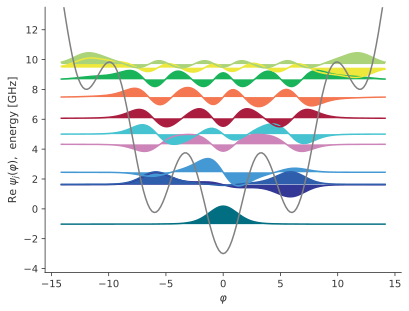

In [2]:
EJ = 3
EC = EJ/4
EL = EJ/20.5

qbt = gfIFQ(EJ = EJ,EC = EC, EL = EL, flux = 0,truncated_dim=20)
e_ops = [qutip.basis(qbt.truncated_dim, i)*qutip.basis(qbt.truncated_dim, i).dag() for i in range(10)]

element = np.abs(qbt.fluxonium.matrixelement_table('n_operator',evals_count=3)[1,2]) 
freq = (qbt.fluxonium.eigenvals()[2]-qbt.fluxonium.eigenvals()[1]) * 2 * np.pi
qbt.fluxonium.plot_wavefunction(which=[0,1,2,3,4,5,6,7,8,9,10])


In [11]:
import json
t_tot_array = np.linspace(5,100,96)
folder_name = 'denser_x_gate_sweep'
# load all results
results = []
for t_tot_idx in range(len(t_tot_array)):
    with open(f"denser_x_gate_sweep/result_t_tot_{t_tot_idx}.json", "r") as f:
        results.append(json.load(f))


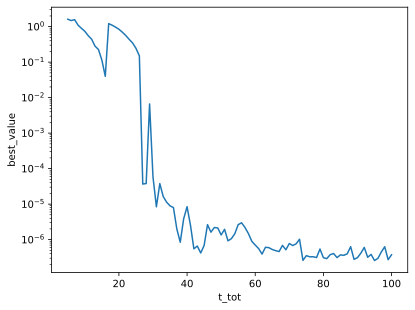

In [12]:
# Plot best_value as a function of t_tot
plt.plot(t_tot_array, [result['best_value'] for result in results])
plt.xlabel('t_tot')
plt.ylabel('best_value')
plt.yscale('log')
plt.show()

In [4]:
state_0_dressed = qutip.basis(qbt.truncated_dim, 1)
state_1_dressed = qutip.basis(qbt.truncated_dim, 2)
state_plus_X_dressed = (state_0_dressed +  state_1_dressed).unit()
state_minus_X_dressed = (state_0_dressed - state_1_dressed).unit()
state_plus_Y_dressed = (state_0_dressed + 1j * state_1_dressed).unit()
state_minus_Y_dressed = (state_0_dressed - 1j * state_1_dressed).unit()

initial_states  = [
                   state_0_dressed,
                   state_1_dressed,
                   state_plus_X_dressed,
                   state_minus_X_dressed,
                   state_plus_Y_dressed,
                   state_minus_Y_dressed
                   ]

temp_in_mK = 20
Q_cap = 1e5
one_over_f_flux_noise_amplitude = 1e-6

c_ops=qbt.get_T1_c_ops(temp_in_mK,
                        Q_cap,
                        one_over_f_flux_noise_amplitude) + qbt.get_Tphi_c_ops(one_over_f_flux_noise_amplitude)
e_ops = [qutip.ket2dm(qutip.basis(qbt.truncated_dim, i)) for i in range(qbt.truncated_dim)]

def truncate_to_computational_and_renormaize(state,i,j):
    if state.isket:
        state = qutip.ket2dm(state)
    arr = state.full()
    arr= arr[[i, j], :][:, [i, j]]
    dm = qutip.Qobj(arr)
    dm = dm/dm.tr()
    return dm
zero = qutip.basis(2, 0)
one = qutip.basis(2, 1)
states_ideal  = [zero,
                one,
                (zero +  one).unit(),
                (zero - one).unit(),
                (zero + 1j * one).unit(),
                (zero - 1j *one).unit()]

states_ideal_after_gate = []
for state in states_ideal:
    states_ideal_after_gate.append(qutip.qip.operations.x_gate() * state)

def calc_average_fidelity_with_phase(phase,dms,states_ideal_after_gate):
    gate = qutip.qip.operations.phasegate(phase)
    fid=[]
    for dm,ket_ideal in zip(dms,states_ideal_after_gate):
        fid.append(qutip.fidelity(gate*dm*gate.dag(), ket_ideal))
    return 1-sum(fid)/len(fid)

fidelity_arr = np.zeros(shape = (len(t_tot_array)))
leak_to_g_arr = np.zeros(shape = (len(t_tot_array)))
additional_leakage_arr = np.zeros(shape = (len(t_tot_array)))
def get_e_pop_j(state, j):
    return qutip.expect(qutip.ket2dm(qutip.basis(qbt.truncated_dim,j)), state)

import os
import pickle
for i,t_tot in tqdm(enumerate(t_tot_array), desc="Processing t_tot values"):
        filename = f'denser_x_gate_sweep/result_t_tot_{t_tot_idx}.json'
        optimization_results = json.load(open(filename))
        
        t_tot = optimization_results['t_tot']
        amp = optimization_results['amp']
        w_d = optimization_results['w_d']
        ramp = optimization_results['ramp']
        best_value = optimization_results['best_value']

        tlist = np.linspace(0,t_tot, 101)
        dir = 'evo_results'
        if not os.path.exists(dir):
            os.makedirs(dir)
        pickle_filename = f'{dir}/decay_evo_results_{t_tot}.pkl'
        if os.path.exists(pickle_filename):
            with open(pickle_filename, 'rb') as f:
                results = pickle.load(f)
        else:
            results =  qbt.run_qutip_mesolve_parrallel(
                initial_states,
                tlist,
                drive_terms = [
                        DriveTerm(
                            driven_op=qutip.Qobj(
                                qbt.fluxonium.n_operator(energy_esys=True)),
                            pulse_shape_func=square_pulse_with_rise_fall,
                            pulse_id='pi',
                            pulse_shape_args={
                                'w_d': w_d,  # Without 2pi
                                'amp': amp,  # Without 2pi
                                't_square': t_tot*(1-2*ramp),
                                't_rise': t_tot*ramp
                            },
                        )
                    ],
                c_ops=c_ops,
                e_ops=e_ops,
                post_processing=None,
            )
            # Store the results to a pickle file
            with open(pickle_filename, 'wb') as f:
                pickle.dump(results, f)
        dms = [truncate_to_computational_and_renormaize(result.states[-1], 1,2) for result in results]
        def objective_function(phase):
            return calc_average_fidelity_with_phase(phase[0], dms, states_ideal_after_gate)
        opt_result = minimize(objective_function,x0=  [0],bounds = [(0, 2*np.pi)], method="Powell")


        fidelity_arr[i] = opt_result.fun
        leakage_to_list = []
        for l in range(len(e_ops)):
            leakage_to_list.append( [get_e_pop_j(result.states[-1], l) for result in results])
        leak_to_g_arr[i] = np.mean(leakage_to_list[0])
        additional_leakage_arr[i]= np.sum(np.abs(np.array(leakage_to_list)))/len(results)- np.mean(leakage_to_list[0]) - np.mean(leakage_to_list[1]) - np.mean(leakage_to_list[2])

0.9998880443285222

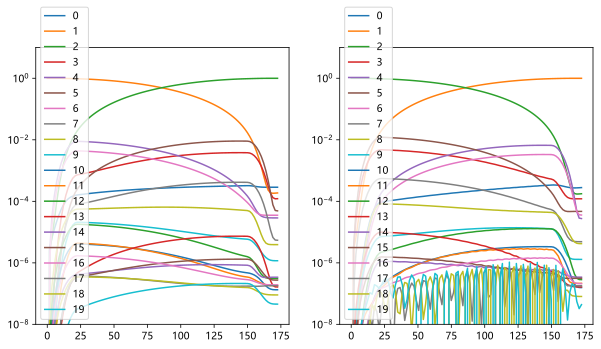

In [7]:
fig, axes = plt.subplots(1,2,figsize = (10,5))
for i, exp in enumerate(results[0].expect):
    axes[0].plot(tlist,exp,label= f"{i}")
for i, exp in enumerate(results[1].expect):
    axes[1].plot(tlist,exp,label= f"{i}")
axes[0].legend()
axes[0].set_yscale('log')
axes[0].set_ylim(1e-8,1e1)
axes[1].legend()
axes[1].set_yscale('log')
axes[1].set_ylim(1e-8,1e1)
plt.show()

In [5]:
def get_e_pop_j(state, j):
    return qutip.expect(qutip.ket2dm(qutip.basis(qbt.truncated_dim,j)), state)

np.mean([get_e_pop_j(result.states[-1], 0) for result in results])

0.0002832179471582073

In [6]:
1 - np.mean([get_e_pop_j(result.states[-1], 0) for result in results])- np.mean([get_e_pop_j(result.states[-1], 1) for result in results])- np.mean([get_e_pop_j(result.states[-1], 2) for result in results])

0.0002454061618593073

In [8]:
results_no_cops  = [ODEsolve_and_post_process(
            y0=initial_states[i],
            tlist=tlist,
            static_hamiltonian=qbt.diag_hamiltonian,
            drive_terms=[
                        DriveTerm(
                            driven_op=qutip.Qobj(
                                qbt.fluxonium.n_operator(energy_esys=True)),
                            pulse_shape_func=square_pulse_with_rise_fall,
                            pulse_id='pi',
                            pulse_shape_args={
                                'w_d': w_d,  # Without 2pi
                                'amp': amp,  # Without 2pi
                                't_square': t_tot*0.85,
                                't_rise': t_tot*0.15
                            },
                        )
                    ],
            # c_ops=c_ops,
            e_ops=e_ops,
            ) for i in range(len(initial_states))]

dms = [truncate_to_computational(result.states[-1], 1,2) for result in results_no_cops]
def objective_function(phase):
    return calc_average_fidelity_with_phase(phase[0], dms, states_ideal_after_gate)
opt_result = minimize(objective_function,x0=  [0],bounds = [(0, 2*np.pi)], method="Powell")
opt_result

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 Total run time:   0.52s*] Elapsed 0.52s / Remaining 00:00:00:00
 Total run time:   0.52s*] Elapsed 0.52s / Remaining 00:00:00:00
 Total run time:   0.56s*] Elapsed 0.56s / Remaining 00:00:00:00
 Total run time:   0.48s*] Elapsed 0.48s / Remaining 00:00:00:00
 Total run time:   0.48s*] Elapsed 0.48s / Remaining 00:00:00:00
 Total run time:   0.53s*] Elapsed 0.53s / Remaining 00:00:00:00


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 2.826824330171007e-10
       x: [ 3.302e+00]
     nit: 2
   direc: [[ 1.000e+00]]
    nfev: 18

In [9]:
colors = ['#4999c3','#d5373d','black','#9467bd','green','#e377c2','#17becf','tab:olive','grey','grey','grey','grey','grey','grey','grey']
z_order_dict = {
    1:-10,
    0:10,
    2:9,
    3:12,
    4:13,
    5:11,
    6:15,
    7: -20,
    8:-30,9:-31,10:-32,11:-33,12:-34
}

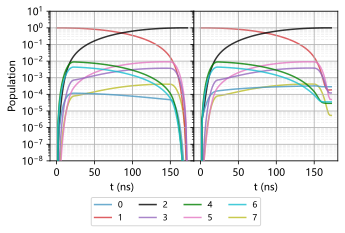

In [14]:
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(5, 3.2))
left = 0.15
subplot_width = 0.4
gs0 = fig.add_gridspec(nrows=1, ncols=1,left=left, right=left+subplot_width,bottom=0.32,top = 0.97)
gs1 = fig.add_gridspec(nrows=1, ncols=1,left=left+subplot_width, right=left+subplot_width+subplot_width,bottom=0.32,top = 0.97)

axes = [fig.add_subplot(gs0[0]),  fig.add_subplot(gs1[0])]

j = 0
# for i in range(len(e_ops)):
for i in range(8):
    alpha = 0.8
    if colors[i] == 'grey':
        alpha = 0.3
    if i <= 7: 
        label= rf"$\langle{i}\rangle$"
    else:
        label = None
    axes[0].plot(tlist,results_no_cops[j].expect[i],label= f"{i}",color=colors[i],alpha=alpha,zorder = z_order_dict[i])

    axes[1].plot(tlist,results[j].expect[i],color=colors[i],alpha=alpha,zorder = z_order_dict[i])

for ax in axes:
    ax.set_yscale('log')
    
    # Major and minor ticks for logarithmic scale
    ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))  # Set major ticks
    ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs='auto', numticks=10))  # Set minor ticks

    ax.grid(which='major', linestyle='-')  # Solid grid lines for major ticks
    ax.grid(which='minor', linestyle='--',alpha=0.2)  # Dashed grid lines for minor ticks

    ax.set_ylim(1e-8, 1e1)
    ax.set_xlabel('t (ns)')

axes[0].set_ylabel('Population')
axes[1].set_ylabel('')
axes[1].set_yticklabels([])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles[:8], labels[:8], loc='lower center',ncol = 4, fontsize='small', bbox_to_anchor=(0.5, 0.02))

fig.savefig('X_gate_simple.pdf')